In [1]:
!nvidia-smi

Thu Jul 11 14:13:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:07.0 Off |                    0 |
| N/A   29C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!pip install wandb


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 628.9 kB/s eta 0:00:0000:01


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, TrainingArguments, Trainer
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import Levenshtein as lev
from datasets import load_metric
from transformers import get_linear_schedule_with_warmup, AdamW
import wandb
# Login to wandb
wandb.login(key="Your-wandb-key")

# Initialize wandb project
wandb.init(project="trocr-ocr-finetuning")
class SpanishDocumentsDataset(Dataset):
    def __init__(self, image_dir, text_dir, processor):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.processor = processor
        self.filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image_file = self.filenames[idx]
        # Derive the corresponding text file name by changing the extension
        text_file = image_file.replace('.jpg', '.txt')
        
        image_path = os.path.join(self.image_dir, image_file)
        text_path = os.path.join(self.text_dir, text_file)
        
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()

        with open(text_path, 'r', encoding='utf-8') as file:
            text = file.read().strip()
        labels = self.processor.tokenizer(text, return_tensors="pt").input_ids.squeeze()
        
        # Treat padding specially for label calculation, if necessary
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {"pixel_values": pixel_values, "labels": labels}



image_dir = '../../data/train/All_line_segments'
text_dir = '../../data/train/All_line_texts'

def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Padding value for labels should be -100 to ignore tokens during loss calculation
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    pixel_values = torch.stack(pixel_values)
    
    return {"pixel_values": pixel_values, "labels": labels}



# Initialize processor and model with correct configurations
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id
model.config.ignore_pad_token_for_loss = True  # Ensure pad tokens are ignored during loss calculation

# Set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
# model.config.max_length = 64
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 5

# Prepare dataset and data loader
dataset = SpanishDocumentsDataset(image_dir, text_dir, processor=processor)

dataset_size = len(dataset)
eval_size = int(dataset_size * 0.1)  # 10% for evaluation
train_size = dataset_size - eval_size  # Remaining for training

# Split the dataset
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=8, collate_fn=collate_fn)



wandb: Currently logged in as: utsavrai (gsoc24_utsavrai). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/ur23/.netrc


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# # To see how the data is loaded, let's fetch a batch from the DataLoader
print(len(train_loader))
for batch in train_loader:
    print(batch['pixel_values'].shape, batch['labels'].shape)
    break  # Just show the first batch for demonstration

225
torch.Size([8, 3, 384, 384]) torch.Size([8, 16])


In [4]:
from torch.optim import AdamW
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import EarlyStoppingCallback

cer_metric = load_metric("cer", trust_remote_code=True)
wer_metric = load_metric("wer", trust_remote_code=True)
bleu_metric = load_metric("bleu", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]

    predictions = logits.argmax(-1)
    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)

    decoded_labels = []
    for label in labels:
        label_filtered = [token for token in label if token != -100]
        decoded_label = processor.decode(label_filtered, skip_special_tokens=True)
        decoded_labels.append(decoded_label)

    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    wer = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    tokenized_preds = [pred.split() for pred in decoded_preds]
    tokenized_refs = [[ref.split()] for ref in decoded_labels]
    
    bleu = bleu_metric.compute(predictions=tokenized_preds, references=tokenized_refs)

    return {"cer": cer, "wer": wer, "bleu": bleu["bleu"]}

model_dir = "../../models/trocr_finetuned_handwritten"
os.makedirs(model_dir, exist_ok=True)

training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,
    gradient_accumulation_steps=1,
    num_train_epochs=5,
    max_grad_norm=1.0,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=100000,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="wandb",
)

total_train_steps = (len(train_loader) * training_args.num_train_epochs)

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=500, 
                                            num_training_steps=total_train_steps)

# Create the EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)

# Define the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizers=(optimizer, scheduler),
    data_collator=collate_fn,
    tokenizer=processor.image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Add the early stopping callback here
)

# Train the model
trainer.train()

/tmp/ipykernel_2385233/12763035.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer", trust_remote_code=True)
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Cer,Wer,Bleu
200,0.519700,0.464252,0.072457,0.193469,0.658560
400,0.441500,0.230811,0.046602,0.124082,0.782082
600,0.222800,0.185232,0.037003,0.095510,0.819750
800,0.124800,0.142078,0.021366,0.063673,0.874001
1000,0.131300,0.130908,0.019972,0.059592,0.875110
1200,0.079600,0.127243,0.020746,0.057959,0.879230
1400,0.039200,0.127243,0.020746,0.057959,0.879230
1600,0.047500,0.127243,0.020746,0.057959,0.879230
1800,0.060800,0.127243,0.020746,0.057959,0.879230
2000,0.108800,0.127243,0.020746,0.057959,0.879230


TrainOutput(global_step=2245, training_loss=0.3869205862482831, metrics={'train_runtime': 915.2987, 'train_samples_per_second': 9.811, 'train_steps_per_second': 2.453, 'total_flos': 1.206585452107137e+19, 'train_loss': 0.3869205862482831, 'epoch': 5.0})

In [5]:
# Use the output_dir from training_args for saving the model and processor
model_dir = training_args.output_dir
os.makedirs(model_dir, exist_ok=True)
trainer.save_model(model_dir)
processor.save_pretrained(model_dir)


# Finish the wandb run
wandb.finish()

Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


eval/bleu,▁▅▆████████
eval/cer,█▅▃▁▁▁▁▁▁▁▁
eval/loss,█▃▂▁▁▁▁▁▁▁▁
eval/runtime,█▆▂▁█▁▄▁█▁▂
eval/samples_per_second,▁▃▆█▁█▅█▁█▇
eval/steps_per_second,▁▃▆█▁█▅█▁█▇
eval/wer,█▄▃▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▅█▂▂▂▂▁▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train/learning_rate,▁▂▃▄▄▅▆▇██▇▇▆▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


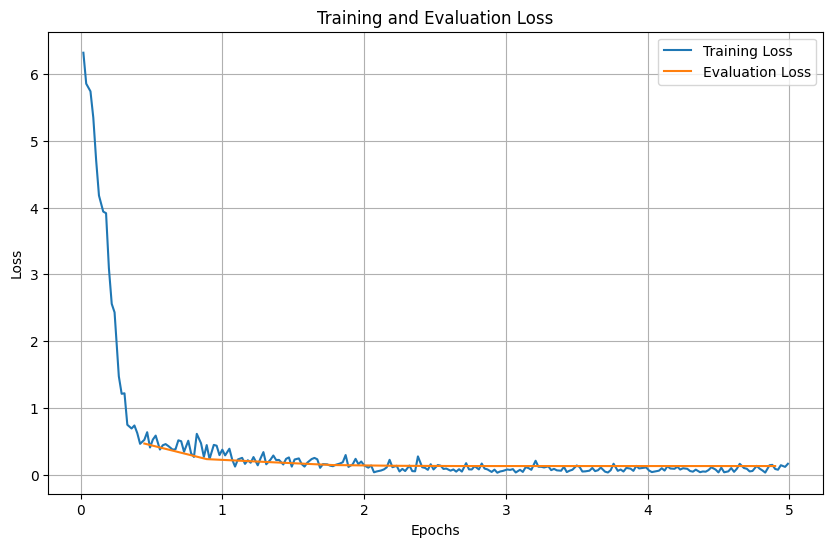

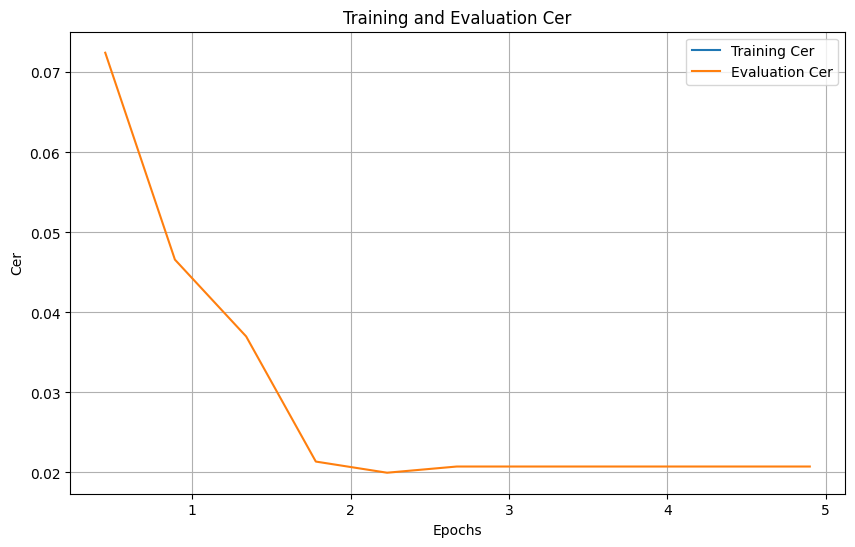

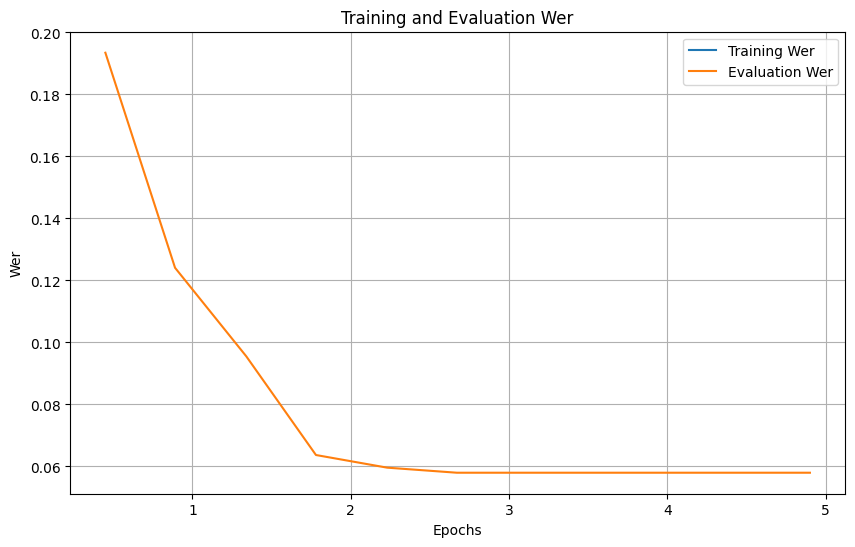

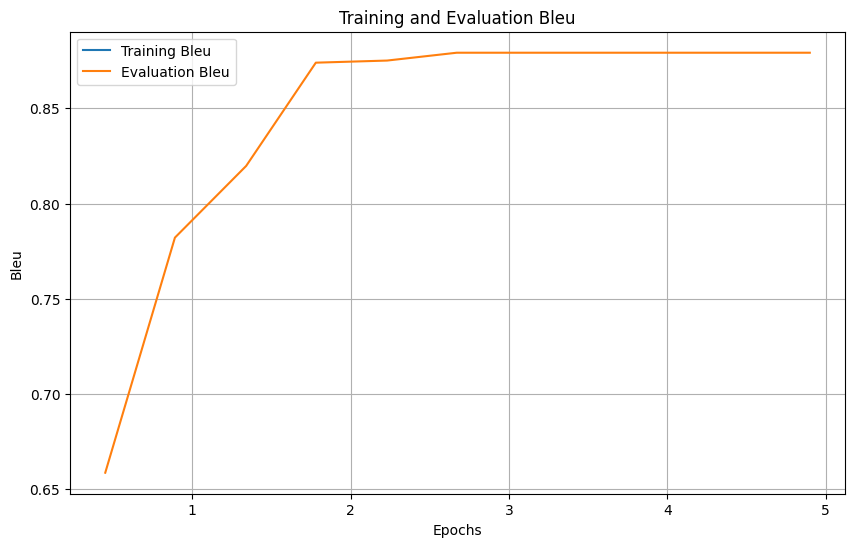

In [6]:
# Extract logs for plotting
train_logs = trainer.state.log_history

# Plotting the training and evaluation curves
def plot_metrics(logs, metric_name):
    train_steps = []
    train_values = []
    eval_steps = []
    eval_values = []

    for log in logs:
        if 'loss' in log and metric_name == 'loss':
            if 'epoch' in log:
                train_steps.append(log['epoch'])
                train_values.append(log['loss'])
        elif f'eval_{metric_name}' in log:
            if 'epoch' in log:
                eval_steps.append(log['epoch'])
                eval_values.append(log[f'eval_{metric_name}'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_values, label=f'Training {metric_name.capitalize()}')
    plt.plot(eval_steps, eval_values, label=f'Evaluation {metric_name.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Training and Evaluation {metric_name.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot loss, CER, WER, and BLEU
plot_metrics(train_logs, 'loss')
plot_metrics(train_logs, 'cer')
plot_metrics(train_logs, 'wer')
plot_metrics(train_logs, 'bleu')


In [3]:
import re
import os
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model_path = "../../models/trocr_finetuned_handwritten"
# processor_path = "../../models/trocr_finetuned_handwritten"

# Load the fine-tuned model and processor
# processor = TrOCRProcessor.from_pretrained(processor_path)
# model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)

# Function to generate text for a single image segment
def generate_text_from_image_segment(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)  # Move pixel_values to the correct device
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Base directory where the page folders are located
base_dir = "../../data/test" 

def sort_key(filename):
    """
    Custom sort function to extract the segment number from the filename
    and use it as the key for sorting.
    """
    match = re.search(r"(\d+)\.jpg", filename)
    if match:
        return int(match.group(1))
    return -1  # Return -1 if the pattern doesn't match

# Iterate through each page's folder
for page_folder in sorted(os.listdir(base_dir)):
    page_path = os.path.join(base_dir, page_folder)
    if os.path.isdir(page_path):
        print(f"Processing {page_folder}:")
        page_texts = []

        # Sort the line segment images numerically based on the segment number
        line_segment_images = sorted([f for f in os.listdir(page_path) if f.endswith('.jpg')], key=sort_key)

        # Iterate through each sorted line segment in the page folder
        for line_segment_image in line_segment_images:
            line_segment_path = os.path.join(page_path, line_segment_image)
            line_text = generate_text_from_image_segment(line_segment_path)
            page_texts.append((line_segment_image, line_text))
        
        # Sort the generated texts based on the filenames
        page_texts.sort(key=lambda x: sort_key(x[0]))

        # Print the texts in sorted order
        for line_segment_image, line_text in page_texts:
            print(f"  {line_segment_image}: {line_text}")

        # Compile and display the full page's text
        full_page_text = "\n".join([text for _, text in page_texts])
        print(f"\nFull text for {page_folder}:")
        print(full_page_text)
        print("\n" + "="*50 + "\n")

cuda
Processing 2:
  1.jpg: dava al postigo, y que Nicolasa se levanto a la venta
  2.jpg: na del aposento a preguntar quien era el que dava
  3.jpg: golpes. Ysabel de Rocafal dize, que estava las
  4.jpg: en el aposento donde dormian, y que aun no se avia
  5.jpg: desnudado, y que baxaton al postigo a hablar con
  6.jpg: don Pedro. Preguntoveles tambien, con que llave
  7.jpg: estava corrado el postigo al tiempo que le aciquiz
  8.jpg: don Pedro, y Nicolasa dize, que estava cerrado con
  9.jpg: llave de loba, y que el dicho don Pedro con la daga
  10.jpg: o machete quito el escalon del postigo de la parte
  11.jpg: de a fuera, y con la daga levanto la puerta hazia
  12.jpg: ba, y rompio la cerradura, y que aviendolo
  13.jpg: de ver su ama otro dia, le avian dicho, que los
  14.jpg: chachos jugando lo avian hecho, y ella lo avia ad
  15.jpg: zado, en lo qual contestan todas ttes, y doña Isabel
  16.jpg: dize, que dutatia un quarto de ova el tomper el
  17.jpg: stigo. Breguntaseles, en

In [11]:
!nvidia-smi

Sat Jun  8 18:42:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0 Off |                  N/A |
|  0%   41C    P8              15W / 320W |  14636MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
